###Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
zf = ZipFile('/content/drive/Shareddrives/Aviral (B.Tech Internship)/nucleisegmentationbenchmark.zip', 'r')
zf.extractall('/content')
zf.close()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch.autograd import Variable
from torchsummary import summary
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch
import functools
%pylab inline
import cv2
import argparse
import os
import glob
import random
import numpy as np
import math
import itertools
import time
import datetime
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


###Parser

In [ ]:
Parser = argparse.ArgumentParser()

Parser.add_argument('--img_height', type=int, default=512, help='size of image height')
Parser.add_argument('--img_width', type=int, default=512, help='size of image width')
Parser.add_argument('--channels', type=int, default=3, help='number of image channels')
Parser.add_argument('--sample_interval', type=int, default=30, help='interval between sampling of images from generators')
Parser.add_argument('--checkpoint_interval', type=int, default=20, help='interval between model checkpoints')
Parser.add_argument('--epoch', type=int, default=69, help='epoch to start training from')
Parser.add_argument('--n_epochs', type=int, default=131, help='number of epochs of training')
Parser.add_argument('--dataset_name', type=str, default="dataset_hist", help='name of the dataset')
Parser.add_argument('--batch_size', type=int, default=5, help='size of the batches')
Parser.add_argument('--lr', type=float, default=0.000004, help='adam: learning rate')
Parser.add_argument('--b1', type=float, default=0.51, help='adam: decay of first order momentum of gradient')
Parser.add_argument('--b2', type=float, default=0.999, help='adam: decay of first order momentum of gradient')
Parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
Parser.add_argument('--decay_epoch', type=int, default=25, help='epoch from which to start lr decay')

args, _ = Parser.parse_known_args()
opt = Parser.parse_args(args=[])
print(opt)

Namespace(b1=0.51, b2=0.999, batch_size=5, channels=3, checkpoint_interval=20, dataset_name='dataset_hist', decay_epoch=25, epoch=69, img_height=512, img_width=512, lr=4e-06, n_cpu=8, n_epochs=131, path='/content/Dataset', sample_interval=30)


### Define Models

In [ ]:
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)

In [ ]:
class ResUnetPlusPlus(nn.Module):
    def __init__(self, channel, filters=[32, 64, 128, 256, 512]):
        super(ResUnetPlusPlus, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.squeeze_excite1 = Squeeze_Excite_Block(filters[0])

        self.residual_conv1 = ResidualConv(filters[0], filters[1], 2, 1)

        self.squeeze_excite2 = Squeeze_Excite_Block(filters[1])

        self.residual_conv2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.squeeze_excite3 = Squeeze_Excite_Block(filters[2])

        self.residual_conv3 = ResidualConv(filters[2], filters[3], 2, 1)

        self.aspp_bridge = ASPP(filters[3], filters[4])

        #self.attn1 = AttentionBlock(filters[2], filters[4], filters[4])
        self.upsample1 = Upsample_(2)
        self.up_residual_conv1 = ResidualConv(filters[4] + filters[2], filters[3], 1, 1)

        #self.attn2 = AttentionBlock(filters[1], filters[3], filters[3])
        self.upsample2 = Upsample_(2)
        self.up_residual_conv2 = ResidualConv(filters[3] + filters[1], filters[2], 1, 1)

        #self.attn3 = AttentionBlock(filters[0], filters[2], filters[2])
        self.upsample3 = Upsample_(2)
        self.up_residual_conv3 = ResidualConv(filters[2] + filters[0], filters[1], 1, 1)

        self.aspp_out = ASPP(filters[1], filters[0])

        self.output_layer = nn.Sequential(nn.Conv2d(filters[0], 1, 1), nn.Sigmoid())

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)

        x2 = self.squeeze_excite1(x1)
        x2 = self.residual_conv1(x2)

        x3 = self.squeeze_excite2(x2)
        x3 = self.residual_conv2(x3)

        x4 = self.squeeze_excite3(x3)
        x4 = self.residual_conv3(x4)

        x5 = self.aspp_bridge(x4)

        #x6 = self.attn1(x3, x5)
        x6 = self.upsample1(x5)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.up_residual_conv1(x6)

        #x7 = self.attn2(x2, x6)
        x7 = self.upsample2(x6)
        x7 = torch.cat([x7, x2], dim=1)
        x7 = self.up_residual_conv2(x7)

        #x8 = self.attn3(x1, x7)
        x8 = self.upsample3(x7)
        x8 = torch.cat([x8, x1], dim=1)
        x8 = self.up_residual_conv3(x8)

        x9 = self.aspp_out(x8)
        out = self.output_layer(x9)

        return out

In [ ]:
##############################
#        Discriminator
##############################

class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc=4, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(PixelDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=2, padding=1, bias=False)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.net(img_input)

###Compile Model and define Loss functions

In [ ]:
## Check for GPU 
cuda = True if torch.cuda.is_available() else False

## Create Tensor type
if cuda:
  Tensor = torch.cuda.FloatTensor
else:
  Tensor = torch.FloatTensor

## Define Loss function
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

## Initialize discriminator and generator models
generator = ResUnetPlusPlus(3)
discriminator = PixelDiscriminator()

if cuda:
    #generator = torch.nn.DataParallel(generator).cuda()
    discriminator = torch.nn.DataParallel(discriminator).cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

generator = generator.to(device)

## Optimisers
opti_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
opti_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [ ]:
!nvidia-smi

Fri Feb 12 13:36:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |   1004MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)
        
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        width, height = img.size
        img_A = img.crop((0, 0, width/2, height))
        img_A = img_A.resize((512,512))

        img_B = img.crop((width/2, 0, width, height))
        img_B = img_B.convert('L')
        img_B = img_B.resize((512,512))
        img_B = np.expand_dims(img_B, axis=-1)

        seed = np.random.randint(2147483647)  # make a seed with numpy generator        
        random.seed(seed)  # apply this seed to img tranfsorms
        img_A = self.transform(img_A)
        random.seed(seed)  # apply this seed to target tranfsorms
        img_B = self.transform(img_B)

        return {'A': img_A, 'B': img_B}
        
    def __len__(self):
        return len(self.files)

###New custom Dataset Class (augmentation)

In [ ]:
class MyDataset(Dataset):
  def __init__(self, root, mode='train', train=True):
      self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))
      self.train = train

  def transform(self, image, mask):
      # Resize
      resize = transforms.Resize(size=(512, 512))
      image = resize(image)
      mask = resize(mask)

      # Random horizontal flipping
      if random.random() > 0.3 and self.train:
          image = transforms.functional.hflip(image)
          mask = transforms.functional.hflip(mask)
      
      # Random vertical flipping
      if random.random() > 0.3 and self.train:
          image = transforms.functional.vflip(image)
          mask = transforms.functional.vflip(mask)

      #ColorJitter
      color = transforms.ColorJitter(brightness=.05, contrast=.05, hue=.05, saturation=.05)
      if random.random() > 0.3 and self.train:
          image = color(image)

      # Transform to tensor
      t = transforms.ToTensor()
      image = t(image)
      mask = t(mask)
      
      # Normalise
      #normalize = transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
      #image = normalize(image)
  
      return image, mask


  def __getitem__(self, index):
      
      img = Image.open(self.files[index % len(self.files)])
      width, height = img.size
      img_A = img.crop((0, 0, width/2, height))


      img_B = img.crop((width/2, 0, width, height))
      img_B = img_B.convert('L')

  
      img_A, img_B = self.transform(img_A, img_B)

      return {'A': img_A, 'B': img_B}

  def __len__(self):
      return len(self.files)

###Create Dataloader

In [ ]:
# Calculate output of image discriminator (PatchGAN)
patch = (1, opt.img_height//2**5, opt.img_width//2**5)

# Configure dataloaders and Data Augmentation
dataloader = DataLoader(MyDataset("/content/nucleisegmentationbenchmark/Train Images", train=True), batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)
print('Length of training batch is: ', len(dataloader))

val_dataloader = DataLoader(MyDataset("/content/nucleisegmentationbenchmark/Test Images", train=False), batch_size=1, shuffle=True, num_workers=opt.n_cpu)
print('Length of validation batch is: ', len(val_dataloader))


Length of training batch is:  20
Length of validation batch is:  24


###Training with new data

In [ ]:
def sample_images(batches_done=None, path=None):
    #Plots histopathology image, ground truth, and generator prediction, from the validation set.
    images = next(iter(val_dataloader))
    real_A = Variable(images['A'].type(Tensor))
    real_B = Variable(images['B'].type(Tensor))
    #real_A = transforms.Normalize((0.5), (0.5))(real_A)
    fake_B = generator(real_A)
    
    img = real_A
    imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic")
    plt.show()
    img = real_B
    imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic",cmap='gray')
    plt.show()
    img = fake_B
    imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic",cmap='gray')
    plt.show()

In [ ]:
G_losses = []
D_losses = []
for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):

        # ----------------------------
        # Model inputs, A = original histopathology image, B = ground truth binary mask
        # ----------------------------
        
        real_B = Variable(batch['B'].type(Tensor))
        real_A = Variable(batch['A'].type(Tensor))        

        ## Adversarial ground truth, blank tensors
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ---------------------
        #  TRAIN GENERATOR
        # ---------------------

        opti_G.zero_grad()
        
        fake_B = generator(real_A)

        # Loss weight of L1 pixel-wise loss between translated image and real image (lambda)
        lambda_ = 0.99

        # Total G loss
        loss_G = (1-lambda_)*criterion_GAN(discriminator(real_A,fake_B), valid) + lambda_*criterion_pixelwise(fake_B, real_B)
        loss_GAN = criterion_GAN(discriminator(real_A,fake_B), valid)
        loss_G.backward()
        opti_G.step()

        # ------------------------
        #  TRAIN DISCRIMINATOR
        # ------------------------

        opti_D.zero_grad()
        loss_D = 0.5 * (criterion_GAN(discriminator(real_A,real_B), valid) + criterion_GAN(discriminator(real_A, fake_B.detach()), fake))
        loss_D.backward()
        opti_D.step()

        #-----------------
        #  Log Progress
        #-----------------

        batches_done = i+ len(dataloader)*epoch 
        

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        #--------------------------
        # Print training progress
        #--------------------------
        
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f] " %
                                                        (epoch, opt.n_epochs,
                                                        i, len(dataloader),
                                                        loss_D.item(), loss_G.item(),
                                                        loss_GAN.item()))
        # ---------------------------------
        # Plot image at sample interval from validation set
        # ---------------------------------
        if batches_done % opt.sample_interval == 0:
            sample_images(batches_done, opt.path)

    if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # -----------------------
        # Save model progress
        # -----------------------
        torch.save(generator.state_dict(), '/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/G_aug_scratch_11Feb_ResUnet++_%d.pth' % (epoch))
        torch.save(discriminator.state_dict(), '/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/D_aug_scratch_11Feb_ResUnet++_%d.pth' % (epoch))


print("\n--------------------------")
print("Training completed")
print("--------------------------")

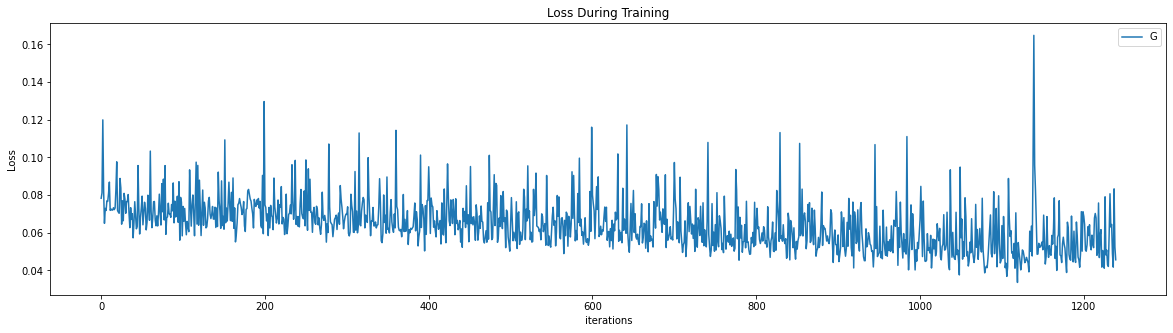




Thu Feb 11 13:20:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    28W /  70W |  14199MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+----

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Loss During Training")
plt.plot(G_losses,label="G")
#plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

print('\n\n')
!nvidia-smi

In [ ]:
torch.save(generator.state_dict(), '/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/G_aug_scratch_11Feb_ResUnet++_69.pth')
torch.save(discriminator.state_dict(), '/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/D_aug_scratch_11Feb_ResUnet++_69.pth')

##################                  ##################
#######    #######                  ########  ########
#####        #####                  #####        #####
###            ###                  ###            ###
#                #                  #                #
###            ###                  ###            ###
#####        #####                  #####        #####
#######    #######                  ########  ########
##################                  ##################
                  ##################
                  #######    #######
                  #####        #####
                  ###            ###
                  #                #
                  ###            ###
                  #####        #####
                  #######    #######
                  ##################
#hytjyutjytggnhdvhgvhgvhgvhgjhkkhkjkjkjkjkjkjhkjhkjhkjh

###See Results  

In [ ]:
#Load Model

generator.load_state_dict(torch.load('/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/ResU-Net++/G_1 Feb_ResUnet++_80.pth'))
discriminator.load_state_dict(torch.load('/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/ResU-Net++/D_1 Feb_ResUnet++_80.pth'))

<All keys matched successfully>

In [ ]:
summary(generator, (3, 512, 512))

In [ ]:
!nvidia-smi

Thu Feb 11 12:27:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |   1057MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

See images from test set

In [ ]:
for i in range(len(val_dataloader)):
  imgs = next(iter(val_dataloader))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  fake_B = generator(real_A)
  img = real_A
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic")
  plt.show()
  img = real_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()
  img = fake_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

See images from training set

In [ ]:
for i in range(len(dataloader)):
  imgs = next(iter(dataloader))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  fake_B = generator(real_A)
  img = real_A
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic")
  plt.show()
  img = real_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()
  img = fake_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()

###Save Generated Images

In [ ]:
class MyTestDataset(Dataset):
  def __init__(self, root, mode='train'):
      self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))

  def __getitem__(self, index):
      
      img = Image.open(self.files[index % len(self.files)])

      width, height = img.size
      img_A = img.crop((0, 0, width/2, height))
      img_A = img_A.convert('L')
      img_A = img_A.resize((512,512))

      img_B = img.crop((width/2, 0, width, height))
      img_B = img_B.convert('L')
      img_B = img_B.resize((512,512))

      t = transforms.ToTensor()
      img_A = t(img_A)
      img_B = t(img_B)
      
      return {'A': img_A, 'B': img_B}

  def __len__(self):
      return len(self.files)

In [ ]:
eval_dataloader_train = DataLoader(MyTestDataset("/content/nucleisegmentationbenchmark/Train Images"), 
                                   batch_size=1, shuffle=True, num_workers=opt.n_cpu)

eval_dataloader_test = DataLoader(MyTestDataset("/content/nucleisegmentationbenchmark/Test Images"), 
                                   batch_size=1, shuffle=True, num_workers=opt.n_cpu)

In [ ]:
#os.mkdir('/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResUnet++ clipped (no aug) results')
#os.mkdir('/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResUnet++ clipped (no aug) results/Train')
#os.mkdir('/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResUnet++ clipped (no aug) results/Test')
#os.mkdir('/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResUnet++ clipped (no aug) results/Train/train')
#os.mkdir('/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResUnet++ clipped (no aug) results/Test/train')

In [ ]:
for j in range(len(eval_dataloader_train)):
  imgs = next(iter(eval_dataloader_train))
  real_A = imgs['A'].cuda()
  real_B = imgs['B'].cuda()
  
  #fake_B = generator(real_A)
  fake_B = real_B
  real_B = real_A
  
  GT_img = real_B
  GT_img = transforms.ToPILImage()(GT_img[0])

  img = fake_B
  img = transforms.ToPILImage()(img[0])

  openCVgt = np.array(GT_img)                                      #convert to cv2 image
  gtimg = cv2.medianBlur(openCVgt,5)                              #apply blur
  ret,th1gt = cv2.threshold(gtimg,69,255,cv2.THRESH_BINARY)         #apply threshold
  groundtruth_img = Image.fromarray(th1gt)                                    #convert back to pil image

  openCVpred = np.array(img)                                      #convert to cv2 image
  predimg = cv2.medianBlur(openCVpred,5)                              #apply blur
  ret,th1pred = cv2.threshold(predimg,69,255,cv2.THRESH_BINARY)         #apply threshold
  predicted_image = Image.fromarray(th1pred)                                    #convert back to pil image

  images = [groundtruth_img, predicted_image]
  widths, heights = [512,512]

  total_width = 1024
  max_height = 512

  new_im = Image.new('L', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += 512

  new_im.save('/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResUnet++ clipped (no aug) results/Train/train/'+'ResU-Net++_train_Merged_'+str(j)+'.jpg')
print('Done!')

Done!


In [ ]:
for j in range(len(eval_dataloader_test)):
  imgs = next(iter(eval_dataloader_test))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
   
  #fake_B = generator(real_A)
  fake_B = real_B
  real_B = real_A
  
  GT_img = real_B
  GT_img = transforms.ToPILImage()(GT_img[0])

  img = fake_B
  img = transforms.ToPILImage()(img[0])

  openCVgt = np.array(GT_img)                                      #convert to cv2 image
  gtimg = cv2.medianBlur(openCVgt,5)                              #apply blur
  ret,th1gt = cv2.threshold(gtimg,69,255,cv2.THRESH_BINARY)         #apply threshold
  groundtruth_img = Image.fromarray(th1gt)                                    #convert back to pil image

  openCVpred = np.array(img)                                      #convert to cv2 image
  predimg = cv2.medianBlur(openCVpred,5)                              #apply blur
  ret,th1pred = cv2.threshold(predimg,69,255,cv2.THRESH_BINARY)         #apply threshold
  predicted_image = Image.fromarray(th1pred)                                    #convert back to pil image

  images = [groundtruth_img, predicted_image]
  widths, heights = [512,512]

  total_width = 1024
  max_height = 512

  new_im = Image.new('L', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += 512

  new_im.save('/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResUnet++ clipped (no aug) results/Test/train/'+'ResU-Net++_test_Merged_'+str(j)+'.jpg')
print('Done!')

Done!


###Define Metrics

In [ ]:
### Dice Loss (input : torch tensor)
def dice_loss(input, target):
    EPS = 1e-6

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    x = ((2. * intersection + EPS) /
              (iflat.sum() + tflat.sum() + EPS))
    return x


### IOU (input : torch tensor)
def jaccard_loss(outputs, labels):
    smooth = 1.
    outputs = outputs.int()
    labels = labels.int()
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + smooth) / (union + smooth)  # We smooth our division to avoid 0/0
    return iou.mean()

from sklearn.utils.extmath import cartesian
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors.kde import KernelDensity
import skimage.io

### Haussdorf Distance (input : torch tensor)
def haussdorf_distance(set1, set2, max_ahd=np.inf):
    if len(set1) == 0 or len(set2) == 0:
        return max_ahd

    set1 = torch.squeeze(set1)
    set2 = torch.squeeze(set2)

    set1 = torch.Tensor.cpu(set1).detach().numpy()[:, :]
    set2 = torch.Tensor.cpu(set2).detach().numpy()[:, :]

    set1 = np.array(set1)
    set2 = np.array(set2)

    assert set1.ndim == 2, 'got %s' % set1.ndim
    assert set2.ndim == 2, 'got %s' % set2.ndim

    assert set1.shape[1] == set2.shape[1], \
        'The points in both sets must have the same number of dimensions, got %s and %s.'\
        % (set2.shape[1], set2.shape[1])

    d2_matrix = pairwise_distances(set1, set2, metric='euclidean')

    res = np.average(np.min(d2_matrix, axis=0)) + \
        np.average(np.min(d2_matrix, axis=1))

    return res

### Surface Distances (input : numpy arrays)    

from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure
from scipy.ndimage.measurements import label, find_objects
from scipy.stats import pearsonr

def hd(result, reference, voxelspacing=None, connectivity=1):
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd

def asd(result, reference, voxelspacing=None, connectivity=1):
    sds = __surface_distances(result, reference, voxelspacing, connectivity)
    asd = sds.mean()
    return asd


def assd(result, reference, voxelspacing=None, connectivity=1):
    assd = numpy.mean( (asd(result, reference, voxelspacing, connectivity), asd(reference, result, voxelspacing, connectivity)) )
    return assd

def __surface_distances(result, reference, voxelspacing=None, connectivity=1):


    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = numpy.asarray(voxelspacing, dtype=numpy.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == numpy.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == numpy.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

In [ ]:
def precision(result, reference):
  result = numpy.atleast_1d(result.astype(numpy.bool))
  reference = numpy.atleast_1d(reference.astype(numpy.bool))
      
  tp = numpy.count_nonzero(result & reference)
  fp = numpy.count_nonzero(result & ~reference)
  
  try:
      precision = tp / float(tp + fp)
  except ZeroDivisionError:
      precision = 0.0
  
  return precision


def recall(result, reference):
  result = numpy.atleast_1d(result.astype(numpy.bool))
  reference = numpy.atleast_1d(reference.astype(numpy.bool))
      
  tp = numpy.count_nonzero(result & reference)
  fn = numpy.count_nonzero(~result & reference)

  try:
      recall = tp / float(tp + fn)
  except ZeroDivisionError:
      recall = 0.0
  
  return recall


def sensitivity(result, reference):
  """
  Sensitivity.
  Same as :func:`recall`, see there for a detailed description.
  """
  return recall(result, reference)


def specificity(result, reference):
  result = numpy.atleast_1d(result.astype(numpy.bool))
  reference = numpy.atleast_1d(reference.astype(numpy.bool))
      
  tn = numpy.count_nonzero(~result & ~reference)
  fp = numpy.count_nonzero(result & ~reference)

  try:
      specificity = tn / float(tn + fp)
  except ZeroDivisionError:
      specificity = 0.0
  
  return specificity


###Evaluate Metrics

In [ ]:
class TestingDataset(Dataset):
  def __init__(self, root, mode='train'):
      self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))

  def __getitem__(self, index):
      
      img = Image.open(self.files[index % len(self.files)])
      """
       
      """
      width, height = img.size
      
      img_A = img.crop((0, 0, width/2, height))
      img_A = img_A.convert('L')
      img_A = img_A.resize((512,512))

      img_B = img.crop((width/2, 0, width, height))
      img_B = img_B.convert('L')
      img_B = img_B.resize((512,512))

      t = transforms.ToTensor()
      img_A = t(img_A)
      img_B = t(img_B)
      
      return {'A': img_A, 'B': img_B}

  def __len__(self):
      return len(self.files)

In [ ]:
def clip(img):      #Input = PIL image
  openCVgt = np.array(img)                                      #convert to cv2 image
  gtimg = cv2.medianBlur(openCVgt,5)                              #apply blur
  ret,th1gt = cv2.threshold(gtimg,69,255,cv2.THRESH_BINARY)         #apply threshold
  groundtruth_img = Image.fromarray(th1gt)                      #convert back to PIL image
  return groundtruth_img

In [ ]:
#@title Default title text
eval_dataloader_train = DataLoader(TestingDataset("/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResU-Net++ results/Train"), batch_size=1, shuffle=True, num_workers=opt.n_cpu)

In [ ]:
iou_list = []
dice_list = []
hausdorff_list = []
assd_list = []
asd_list = []

for i in range(len(eval_dataloader_train)):
  imgs = next(iter(eval_dataloader_train))
  
  t = transforms.ToTensor()
  i_real_B = t(clip(transforms.ToPILImage()(imgs['A'][0])))
  i_fake_B = t(clip(transforms.ToPILImage()(imgs['B'][0])))
  
  real_B = Variable(imgs['A'].type(Tensor))
  fake_B = Variable(imgs['B'].type(Tensor))


  num = jaccard_loss(fake_B, real_B)
  iou_list.append(num)
  
  num = dice_loss(i_fake_B, i_real_B)
  dice_list.append(num)

  num = haussdorf_distance(fake_B, real_B)
  hausdorff_list.append(num)

  i_real_B = torch.squeeze(i_real_B)
  i_fake_B = torch.squeeze(i_fake_B)

  i_real_B = torch.Tensor.cpu(i_real_B).detach().numpy()[:, :]
  i_fake_B = torch.Tensor.cpu(i_fake_B).detach().numpy()[:, :]

  num = asd(i_fake_B, i_real_B)
  asd_list.append(num)

  num = assd(i_fake_B, i_real_B)
  assd_list.append(num)
  
  real_A = None
  real_B = None
  fake_B = None
  torch.cuda.empty_cache()

##----------------------------------------------------------------------------------------------------------------------------------------------
print('\n\n\n-------------------------------------------')
print('-----Performance Metrics on Train set------\n')
print('IOU = '                                  +str(torch.mean(torch.stack(iou_list))))
print('Dice = '                                 +str(torch.mean(torch.stack(dice_list))))
print('Haussdorf = '                            +str(np.mean(hausdorff_list)))
print('ASSD = '   +str(np.mean(assd_list)))
print('ASD = '             +str(np.mean(asd_list)))




-------------------------------------------
-----Performance Metrics on Train set------

IOU = tensor(0.8654, device='cuda:0')
Dice = tensor(0.9351)
Haussdorf = 3.2829328
ASSD = 1.0957726667735346
ASD = 1.4035169790153772


In [ ]:
precision_list = []
recall_list = []
specificity_list = []
sensitivity_list = []

for i in range(len(eval_dataloader_train)):
  imgs = next(iter(eval_dataloader_train))
  
  t = transforms.ToTensor()
  i_real_B = t(clip(transforms.ToPILImage()(imgs['A'][0])))
  i_fake_B = t(clip(transforms.ToPILImage()(imgs['B'][0])))
  
  real_B = Variable(imgs['A'].type(Tensor))
  fake_B = Variable(imgs['B'].type(Tensor))

  i_real_B = torch.squeeze(i_real_B)
  i_fake_B = torch.squeeze(i_fake_B)

  i_real_B = torch.Tensor.cpu(i_real_B).detach().numpy()[:, :]
  i_fake_B = torch.Tensor.cpu(i_fake_B).detach().numpy()[:, :]

  num = precision(i_fake_B, i_real_B)
  precision_list.append(num)
  
  num = recall(i_fake_B, i_real_B)
  recall_list.append(num)

  num = specificity(i_fake_B, i_real_B)
  specificity_list.append(num)  
  
  num = sensitivity(i_fake_B, i_real_B)
  sensitivity_list.append(num)

  real_A = None
  real_B = None
  fake_B = None
  torch.cuda.empty_cache()

##----------------------------------------------------------------------------------------------------------------------------------------------
print('\n\n\n-------------------------------------------')
print('-----Performance Metrics on Train set------\n')
print('Precision = '      +str(np.mean(precision_list)))
print('Recall = '           +str(np.mean(recall_list)))
print('Specificity = '      +str(np.mean(specificity_list)))
print('Sensitivity = '           +str(np.mean(sensitivity_list)))





-------------------------------------------
-----Performance Metrics on Train set------

Precision = 0.9358596225303248
Recall = 0.9192826406480196
Specificity = 0.9892831769522248
Sensitivity = 0.9192826406480196


In [ ]:
eval_dataloader_test = DataLoader(TestingDataset("/content/drive/Shareddrives/Aviral (B.Tech Internship)/ResU-Net++ results/Test"), batch_size=1, shuffle=True, num_workers=opt.n_cpu)

In [ ]:
iou_list_test = []
dice_list_test = []
hausdorff_list_test = []
assd_list_test = []
asd_list_test = []

for i in range(len(eval_dataloader_test)):
  imgs = next(iter(eval_dataloader_test))
  
  t = transforms.ToTensor()
  i_real_B = t(clip(transforms.ToPILImage()(imgs['A'][0])))
  i_fake_B = t(clip(transforms.ToPILImage()(imgs['B'][0])))
  
  real_B = Variable(imgs['A'].type(Tensor))
  fake_B = Variable(imgs['B'].type(Tensor))


  num = jaccard_loss(fake_B, real_B)
  iou_list_test.append(num)
  
  num = dice_loss(i_fake_B, i_real_B)
  dice_list_test.append(num)

  num = haussdorf_distance(fake_B, real_B)
  hausdorff_list_test.append(num)

  i_real_B = torch.squeeze(i_real_B)
  i_fake_B = torch.squeeze(i_fake_B)

  i_real_B = torch.Tensor.cpu(i_real_B).detach().numpy()[:, :]
  i_fake_B = torch.Tensor.cpu(i_fake_B).detach().numpy()[:, :]

  num = asd(i_fake_B, i_real_B)
  asd_list_test.append(num)

  num = assd(i_fake_B, i_real_B)
  assd_list_test.append(num)
  
  real_A = None
  real_B = None
  fake_B = None
  torch.cuda.empty_cache()

##---------------------------------------------------------------------

print('\n\n\n-------------------------------------------')
print('-----Performance Metrics on Test set-----\n')
print('IOU = '                                  +str(torch.mean(torch.stack(iou_list_test))))
print('Dice = '                                 +str(torch.mean(torch.stack(dice_list_test))))
print('Haussdorf = '                            +str(np.mean(hausdorff_list_test)))
print('Average Surface Symmetric Distance = '   +str(np.mean(assd_list_test)))
print('Average Surface Distance = '             +str(np.mean(asd_list_test)))




-------------------------------------------
-----Performance Metrics on Test set-----

IOU = tensor(0.9283, device='cuda:0')
Dice = tensor(0.7336)
Haussdorf = 5.5631943
Average Surface Symmetric Distance = 4.3540540931886484
Average Surface Distance = 5.978530741613258


In [ ]:
precision_list_test = []
recall_list_test = []
specificity_list_test = []
sensitivity_list_test = []

for i in range(len(eval_dataloader_test)):
  imgs = next(iter(eval_dataloader_test))
  
  t = transforms.ToTensor()
  i_real_B = t(clip(transforms.ToPILImage()(imgs['A'][0])))
  i_fake_B = t(clip(transforms.ToPILImage()(imgs['B'][0])))
  
  real_B = Variable(imgs['A'].type(Tensor))
  fake_B = Variable(imgs['B'].type(Tensor))

  i_real_B = torch.squeeze(i_real_B)
  i_fake_B = torch.squeeze(i_fake_B)

  i_real_B = torch.Tensor.cpu(i_real_B).detach().numpy()[:, :]
  i_fake_B = torch.Tensor.cpu(i_fake_B).detach().numpy()[:, :]

  num = precision(i_fake_B, i_real_B)
  precision_list_test.append(num)
  
  num = recall(i_fake_B, i_real_B)
  recall_list_test.append(num)

  num = specificity(i_fake_B, i_real_B)
  specificity_list_test.append(num)  
  
  num = sensitivity(i_fake_B, i_real_B)
  sensitivity_list_test.append(num)

  real_A = None
  real_B = None
  fake_B = None
  torch.cuda.empty_cache()

##----------------------------------------------------------------------------------------------------------------------------------------------
print('\n\n\n-------------------------------------------')
print('-----Performance Metrics on Test set------\n')
print('Precision = '      +str(np.mean(precision_list_test)))
print('Recall = '           +str(np.mean(recall_list_test)))
print('Specificity = '      +str(np.mean(specificity_list_test)))
print('Sensitivity = '           +str(np.mean(sensitivity_list_test)))




-------------------------------------------
-----Performance Metrics on Test set------

Precision = 0.7375289283789593
Recall = 0.755323037446637
Specificity = 0.9385837806967144
Sensitivity = 0.755323037446637


In [ ]:
torch.cuda.empty_cache()